['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
Column Names:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Shape: (541909, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Describe:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250    

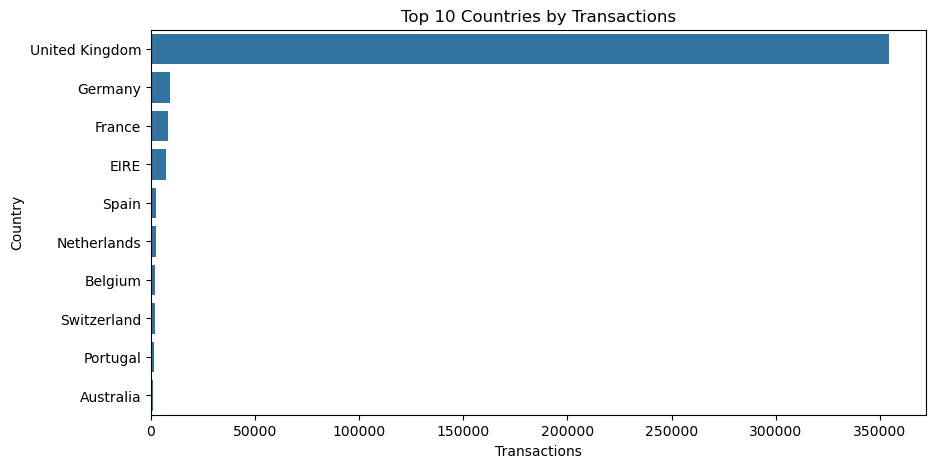

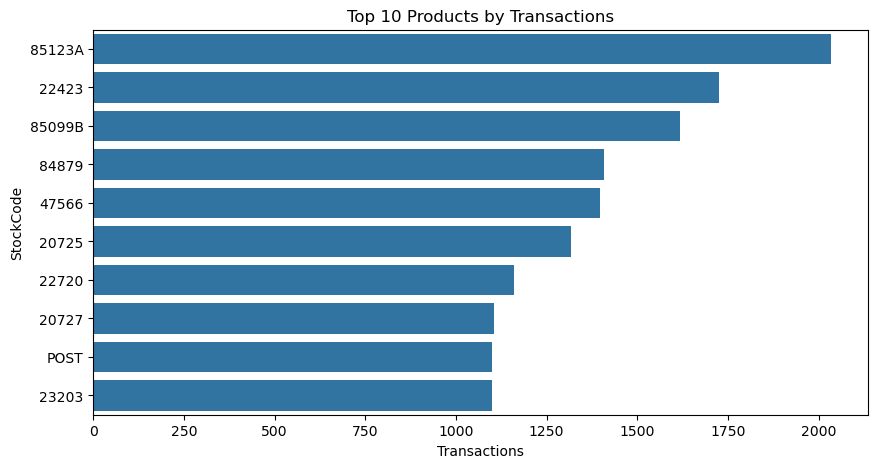

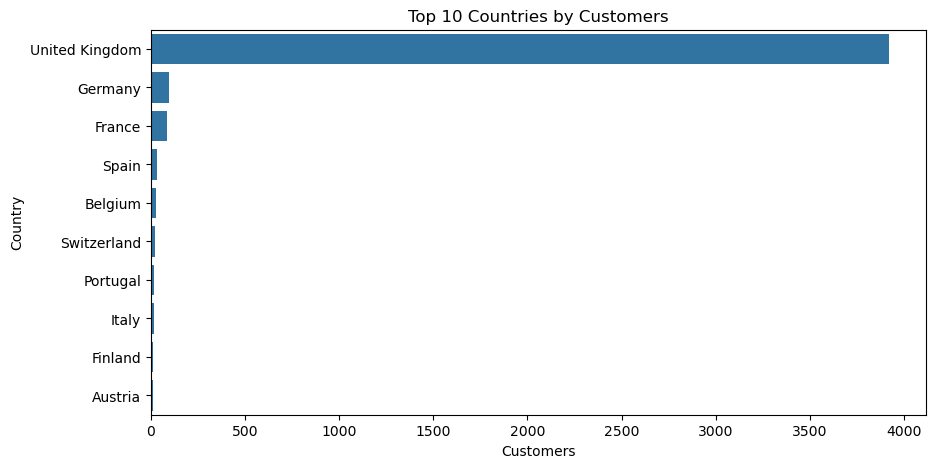

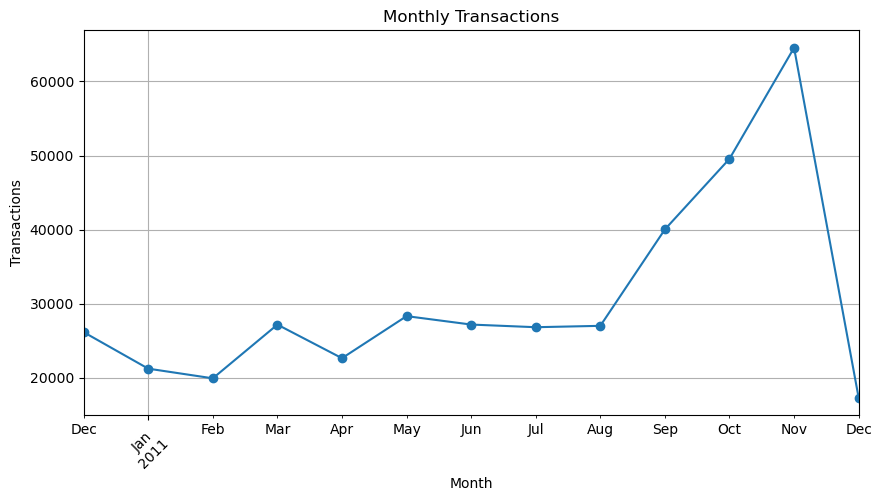

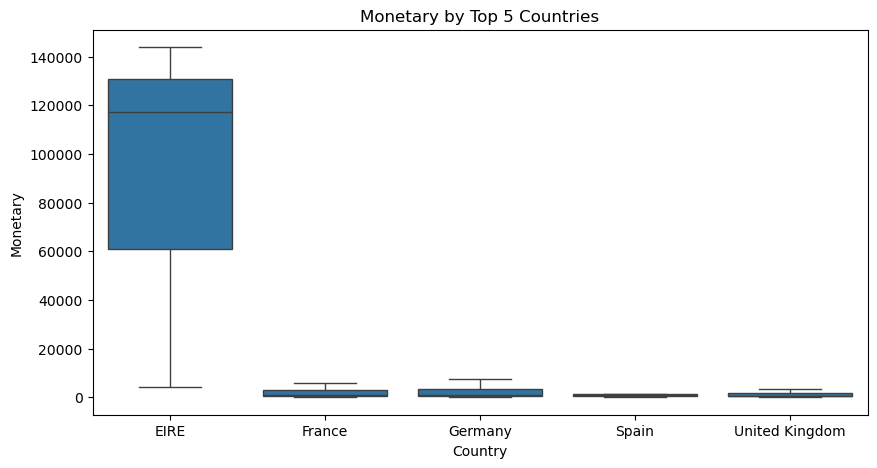

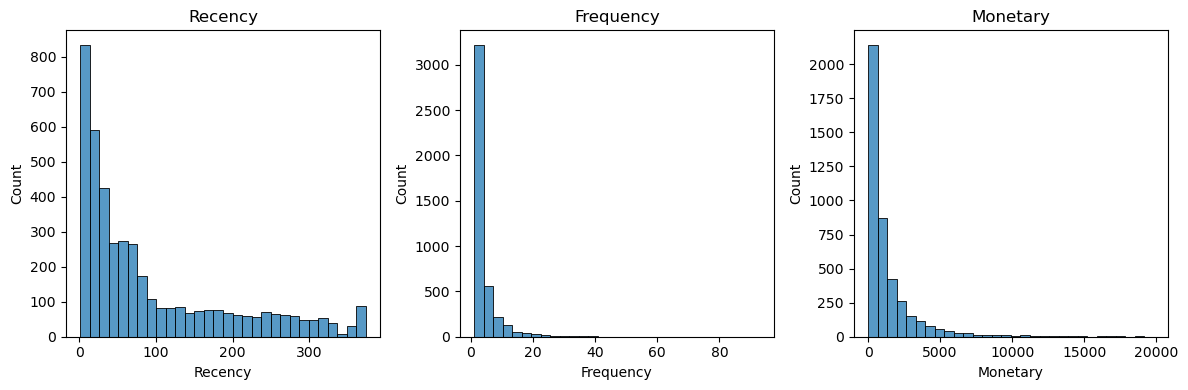

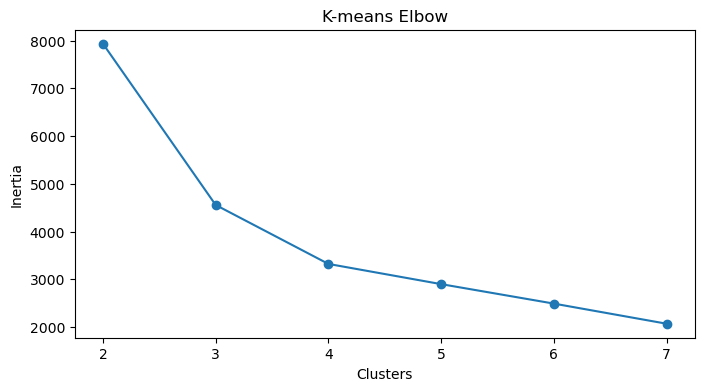

K-means Silhouette: 0.507


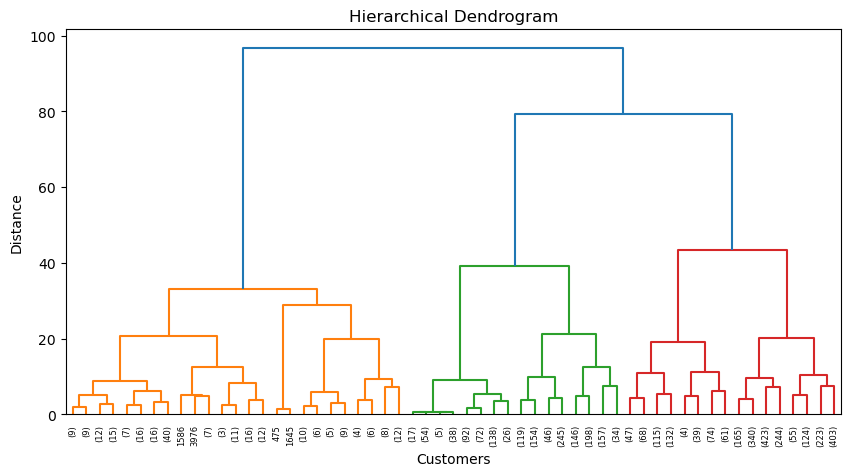

Hierarchical Silhouette: 0.401
DBSCAN Silhouette: 0.643

Model Comparison:
K-means: 0.507
Hierarchical: 0.401
DBSCAN: 0.643

Best Model: DBSCAN


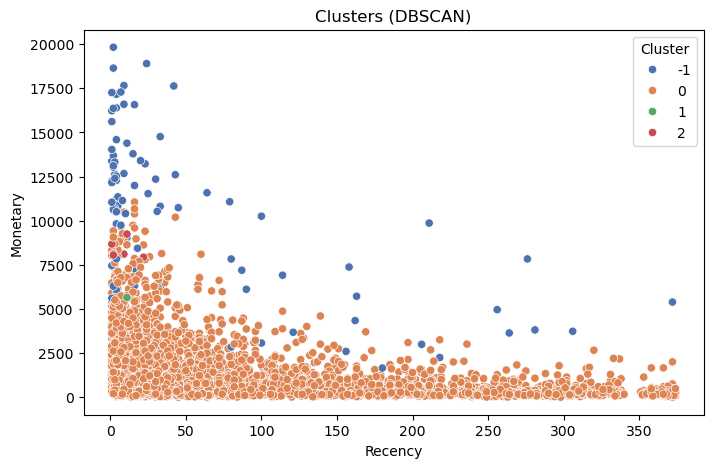


Cluster Summary:
   Cluster  Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
0       -1    51.924731      20.612903  10304.348387              93
1        0    94.376611       3.435322   1198.712922            4190
2        1     4.857143      24.857143   5276.672857               7
3        2     9.000000      25.400000   8402.216000               5


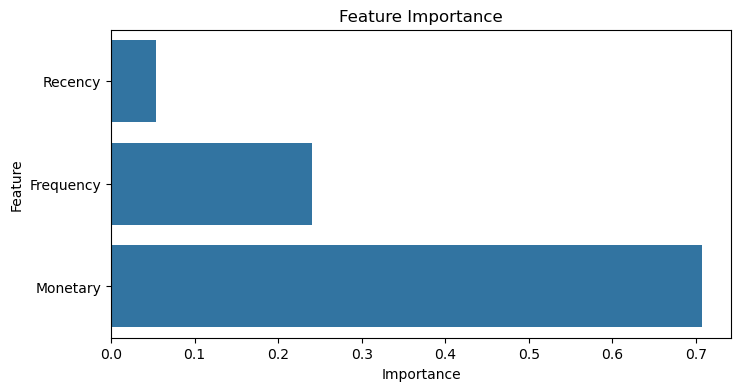


Recommendations:
Cluster 0:
- High-value: VIP discounts, exclusive products
- 93 customers

Cluster 1:
- At-risk: Re-engagement emails, personalized offers
- 4190 customers

Cluster 2:
- Low-value: Bundles, low-cost items
- 7 customers

Cluster 3:
- High-value: VIP discounts, exclusive products
- 5 customers



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import os
import warnings



# Load dataset
dataset_path = 'Ecommerce.csv'
df = pd.read_csv(dataset_path, encoding='ISO-8859-1')

print(list(df.columns))

# Rename BOM-affected column
df = df.rename(columns={'ï»¿InvoiceNo': 'InvoiceNo'})

# Explore dataset
print("Column Names:")
print(list(df.columns))
print("\nShape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescribe:")
print(df.describe())
print("\nHead:")
print(df.head())

# Check InvoiceDate values
print("\nUnique InvoiceDate (first 20):")
print(df['InvoiceDate'].astype(str).unique()[:20])

# Data Cleaning
initial_rows = len(df)

# Parse InvoiceDate
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%m-%d-%Y %H:%M')  # 12-01-2010 08:26
    except:
        try:
            return pd.to_datetime(date_str, format='%m-%d-%y %H:%M')  # 12-10-10 15:40
        except:
            return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M')  # 9/21/2011 15:39

df['InvoiceDate'] = df['InvoiceDate'].apply(parse_dates)

# Drop invalid dates
invalid_dates = df['InvoiceDate'].isna().sum()
if invalid_dates > 0:
    print(f"Drop {invalid_dates} invalid dates")
    print("Sample invalid dates:")
    print(df[df['InvoiceDate'].isna()]['InvoiceDate'].head())
    df = df.dropna(subset=['InvoiceDate'])
else:
    print("All InvoiceDate parsed")
print(f"Rows after date cleaning: {len(df)} ({initial_rows - len(df)} dropped)")

# Drop Description
df = df.drop('Description', axis=1)

# Convert types
df = df.astype({'InvoiceNo': str, 'StockCode': str, 'CustomerID': float, 'Country': str})

# Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Filter negative quantities
df = df[df['Quantity'] > 0]

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Post-cleaning check
print("\nPost-Cleaning Info:")
print(df.info())
print("\nPost-Cleaning Describe:")
print(df.describe())

# EDA
# Top 10 countries by transactions
plt.figure(figsize=(10, 5))
country_counts = df['Country'].value_counts().head(10)
sns.barplot(x=country_counts.values, y=country_counts.index)
plt.title('Top 10 Countries by Transactions')
plt.xlabel('Transactions')
plt.ylabel('Country')
plt.show()

# Top 10 products by StockCode
plt.figure(figsize=(10, 5))
product_counts = df['StockCode'].value_counts().head(10)
sns.barplot(x=product_counts.values, y=product_counts.index)
plt.title('Top 10 Products by Transactions')
plt.xlabel('Transactions')
plt.ylabel('StockCode')
plt.show()

# Unique customers by country
plt.figure(figsize=(10, 5))
customer_counts = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head(10)
sns.barplot(x=customer_counts.values, y=customer_counts.index)
plt.title('Top 10 Countries by Customers')
plt.xlabel('Customers')
plt.ylabel('Country')
plt.show()

# Monthly transactions
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_transactions = df.groupby('InvoiceMonth').size()
plt.figure(figsize=(10, 5))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Monthly Transactions')
plt.xlabel('Month')
plt.ylabel('Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# RFM by top 5 countries
top_countries = df['Country'].value_counts().head(5).index
rfm_country = df.groupby(['Country', 'CustomerID']).agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() + pd.Timedelta(days=1) - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm_country.columns = ['Country', 'CustomerID', 'Recency', 'Frequency', 'Monetary']
plt.figure(figsize=(10, 5))
sns.boxplot(data=rfm_country[rfm_country['Country'].isin(top_countries)], 
            x='Country', y='Monetary', showfliers=False)
plt.title('Monetary by Top 5 Countries')
plt.show()

# Feature Engineering
# RFM features
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove outliers
rfm = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.99)]

# Plot RFM
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30)
plt.title('Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title('Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title('Monetary')
plt.tight_layout()
plt.show()

# Clustering
# Scale RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# K-means
inertia = []
kmeans_sil_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        kmeans_sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

plt.figure(figsize=(8, 4))
plt.plot(range(2, 8), inertia, marker='o')
plt.title('K-means Elbow')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)
kmeans_sil = silhouette_score(rfm_scaled, rfm['KMeans_Cluster'])
print(f"K-means Silhouette: {kmeans_sil:.3f}")

# Hierarchical
Z = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

rfm['Hierarchical_Cluster'] = fcluster(Z, t=4, criterion='maxclust')
hierarchical_sil = silhouette_score(rfm_scaled, rfm['Hierarchical_Cluster'])
print(f"Hierarchical Silhouette: {hierarchical_sil:.3f}")

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)
if len(np.unique(rfm['DBSCAN_Cluster'])) > 1:
    dbscan_sil = silhouette_score(rfm_scaled[rfm['DBSCAN_Cluster'] != -1], 
                                 rfm['DBSCAN_Cluster'][rfm['DBSCAN_Cluster'] != -1])
    print(f"DBSCAN Silhouette: {dbscan_sil:.3f}")
else:
    dbscan_sil = -1
    print("DBSCAN: No valid clusters")

# Compare models
print("\nModel Comparison:")
print(f"K-means: {kmeans_sil:.3f}")
print(f"Hierarchical: {hierarchical_sil:.3f}")
print(f"DBSCAN: {dbscan_sil:.3f}" if dbscan_sil != -1 else "DBSCAN: N/A")

sil_scores = {'K-means': kmeans_sil, 'Hierarchical': hierarchical_sil, 'DBSCAN': dbscan_sil}
best_model = max(sil_scores, key=lambda x: sil_scores[x] if sil_scores[x] != -1 else -float('inf'))
print(f"\nBest Model: {best_model}")

# Assign clusters
if best_model == 'K-means':
    rfm['Cluster'] = rfm['KMeans_Cluster']
elif best_model == 'Hierarchical':
    rfm['Cluster'] = rfm['Hierarchical_Cluster']
else:
    rfm['Cluster'] = rfm['DBSCAN_Cluster']

# Plot clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='deep')
plt.title(f'Clusters ({best_model})')
plt.show()

# Cluster summary
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_summary.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
print("\nCluster Summary:")
print(cluster_summary)

# Predictive Model
# RandomForest for high-value customers

rfm['HighValue'] = (rfm['Monetary'] > rfm['Monetary'].quantile(0.75)).astype(int)
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['HighValue']
X_scaled = scaler.fit_transform(X)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Recency', 'Frequency', 'Monetary'],
    'Importance': rf_model.feature_importances_
})
plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

# Recommendations
print("\nRecommendations:")
for i in range(len(cluster_summary)):
    cluster = cluster_summary.iloc[i]
    print(f"Cluster {i}:")
    if cluster['Avg_Monetary'] > cluster_summary['Avg_Monetary'].mean():
        print("- High-value: VIP discounts, exclusive products")
    elif cluster['Avg_Recency'] > cluster_summary['Avg_Recency'].mean():
        print("- At-risk: Re-engagement emails, personalized offers")
    else:
        print("- Low-value: Bundles, low-cost items")
    print(f"- {int(cluster['Customer_Count'])} customers\n")

# Save cluster summary
cluster_summary.to_csv('cluster_summary.csv', index=False)